In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import os
import cv2

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# model & preprocess
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications import ResNet50
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers

# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# 讀取圖片
data_path = 'D:/Coding Project/GitHub/ML100-Days/data/Kaggle/Final exam for ML 100 marathon by Cupoy/image_data/'
array_of_img = [] # this if for store all of the image data
flower_name = []
img_id = []
img_size = 256 # 150

# Train data
flower_daisy_dir = 'train/daisy/'
flower_dandelion_dir = 'train/dandelion/'
flower_rose_dir = 'train/rose/'
flower_sunflower_dir = 'train/sunflower/'
flower_tulip_dir = 'train/tulip/'

# Test data
flower_test_dir = 'test/'

In [3]:
def assign_label(img, flower_type):
    return flower_type

In [4]:
# this function is for load image
def make_train_data(flower_type, DIR):
    # this loop is for read each image in this folder, DIR is the foder name with images.
    for filename in os.listdir(data_path + DIR):        
        label = assign_label(filename, flower_type)        
        path = os.path.join(data_path, DIR, filename)       
        img = cv2.imread(path, cv2.IMREAD_COLOR) # img is used to store the image data 
        img = cv2.resize(img, (img_size, img_size))
        img_name = filename.replace(".jpg", "")
        
        array_of_img.append(np.array(img))      
        flower_name.append(str(label))
        img_id.append(img_name)

In [5]:
# Get size of each class
size_daisy = len(os.listdir(data_path + flower_daisy_dir))
size_dandelion = len(os.listdir(data_path + flower_dandelion_dir))
size_sunflower = len(os.listdir(data_path + flower_sunflower_dir))
size_rose = len(os.listdir(data_path + flower_rose_dir))
size_tulip = len(os.listdir(data_path + flower_tulip_dir))
size_test = len(os.listdir(data_path + flower_test_dir))

# Print size of each class
print('daisy data size: {}'.format(size_daisy)) # 雛菊
print('dandelion data size: {}'.format(size_dandelion)) # 蒲公英
print('sunflower data size: {}'.format(size_sunflower)) # 向日葵
print('rose data size: {}'.format(size_rose)) # 玫瑰
print('tulip data size: {}'.format(size_tulip)) # 鬱金香
print('test data size: {}'.format(size_test)) # 測試資料

daisy data size: 500
dandelion data size: 687
sunflower data size: 488
rose data size: 515
tulip data size: 633
test data size: 2000


In [7]:
make_train_data('Daisy', flower_daisy_dir)
make_train_data('Dandelion', flower_dandelion_dir)
make_train_data('Sunflower', flower_sunflower_dir)
make_train_data('Rose', flower_rose_dir)
make_train_data('Tulip', flower_tulip_dir)

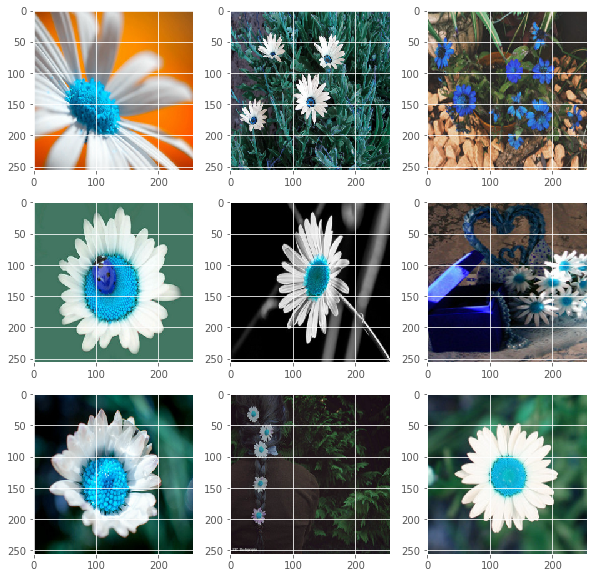

In [7]:
# Plot figure
fig = plt.figure(figsize = (10, 10))
for i in range(9):
    img = array_of_img[i]
    fig.add_subplot(3, 3, i+1)
    plt.imshow(img)
plt.show()

In [8]:
uni_flower_name = list(set(flower_name))
uni_flower_name

['Sunflower', 'Tulip', 'Daisy', 'Rose', 'Dandelion']

In [9]:
# Check size compatibility
(len(flower_name), len(array_of_img))

(2823, 2823)

In [10]:
batch_size = 128
num_classes = 5 # Flower type 共有 5 個類別
epochs = 100 # 訓練的 epochs 數量

In [11]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_encode = le.fit_transform(flower_name)

# 對 label 進行 one-hot encoding (Y本是純數字)
Y = keras.utils.to_categorical(label_encode, num_classes)

# # Transform data to float32 and Normalize
X = np.array(array_of_img).astype('float32')/255
print('X shape:', X.shape)

X shape: (2823, 256, 256, 3)


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

# Flatten to one-dimention
x_train_flatten = x_train.reshape(number_of_train, x_train.shape[1] * x_train.shape[2], 3)
x_test_flatten = x_test.reshape(number_of_test, x_test.shape[1] * x_test.shape[2], 3)
print("x train flatten", x_train_flatten.shape)
print("x test flatten", x_test_flatten.shape)

x train flatten (2399, 65536, 3)
x test flatten (424, 65536, 3)


In [13]:
def create_model_CNN():
    # 建立 CNN 神經網路模型
    model = Sequential()

    # 建立第一個卷積層，32 個內核，內核大小 5 x 5
    model.add(Conv2D(32, (5, 5), padding = 'same', activation = 'relu', input_shape = x_train.shape[1:], name='conv_1'))
    model.add(Conv2D(32, (3, 3), activation='relu', name='conv_2'))
    model.add(MaxPooling2D(pool_size = (2, 2), name='maxpool_1'))
    model.add(Dropout(0.25))

    # 建立兩個卷積層、池化層，不需要再輸入 input_shape
    model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu', name='conv_3'))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv_4'))
    model.add(MaxPooling2D(pool_size = (2, 2), name='maxpool_2'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu', name='conv_5'))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv_6'))
    model.add(MaxPooling2D(pool_size = (2, 2), name='maxpool_3'))    
  
    # 新增平坦層
    model.add(Flatten())

    # 建立一個全連接層
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dropout(0.5))
    
    # 建立第二個全連接層
    model.add(Dense(128, activation='relu', name='dense_2'))

    # 建立一個輸出層, 並採用softmax
    model.add(Dense(num_classes, activation = 'softmax', name='output'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(lr=0.001), metrics = ['accuracy']) 
    return model

In [14]:
import sys
sys.path.append('D:/Coding Project/GitHub\ML100-Days/resnet_builder.py')
from resnet_builder import resnet

def create_model_ResNet50():
    model = resnet(input_shape = x_train.shape[1:], num_classes = num_classes)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(lr=0.001), metrics = ['accuracy'])
    return model

In [15]:
model_CNN = create_model_CNN()
model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
conv_2 (Conv2D)              (None, 254, 254, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 127, 127, 64)      18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 125, 125, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 62, 62, 64)        0         
__________

In [16]:
model_ResNet50 = create_model_ResNet50()
model_ResNet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [17]:
data_generator = ImageDataGenerator( 
                                        rescale = 1./255,
                                        rotation_range = 40,
                                        width_shift_range = 0.4,
                                        height_shift_range = 0.4,
                                        shear_range=0.2,
                                        zoom_range=0.3,
                                        horizontal_flip = True
                                    )

# Flow training images in batches of 32 using data_generator
train_generator = data_generator.flow(
                                        x_train,
                                        y_train,
                                        batch_size = batch_size
                                     )
val_generator = data_generator.flow(
                                        x_test,
                                        y_test,
                                        batch_size = batch_size
                                    )

from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = "val_loss", patience = 10, verbose = 1 )

from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(factor = 0.1, min_lr = 1e-12, monitor = 'val_acc', patience = 3, verbose = 1)

### Traing Model

In [ ]:
# CNN
model_CNN_info = model_CNN.fit_generator(
                                generator = train_generator,
                                steps_per_epoch = len(x_train) / batch_size,
                                epochs = epochs,
                                callbacks = [earlystop, reduce_lr],
                                validation_steps = len(x_test) / batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
                                validation_data = val_generator, 
                                verbose = 2
                             )
score = model_CNN.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50


In [ ]:
# ResNet50
model_ResNet50_info = model_ResNet50.fit_generator(
                                generator = train_generator,     
                                steps_per_epoch = len(train_data) / batch_size, # -> 106 # images 3392 = steps * batch_size = 106 * 32 
                                epochs = epochs, 
                                callbacks = [earlystop, reduce_lr],
                                validation_steps = len(x_test) / batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
                                validation_data = val_generator, 
                                verbose = 2
                            )
score = model_ResNet50.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2399 samples, validate on 424 samples
Epoch 1/50


In [18]:
# Plots for training and testing process: loss and accuracy
def plot_model_history(model_name, history, epochs):
    print(model_name)
    plt.figure(figsize=(15, 5))
    
    # summarize history for accuracy
    plt.subplot(1, 2 ,1)
    plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
    plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
    plt.xticks(np.arange(0, epochs+1, epochs/10))
    plt.title('Training Accuracy vs. Validation Accuracy')
    plt.xlabel('Num of Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'validation'], loc='best') 
    
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
    plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
    plt.xticks(np.arange(0, epochs+1, epochs/10))
    plt.title('Training Loss vs. Validation Loss')
    plt.xlabel('Num of Epochs')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='best')
    
    plt.show()

In [19]:
plot_model_history('model_CNN', model_CNN_info.history, epochs)
plot_model_history('model_ResNet50', model_ResNet50_info.history, epochs)

NameError: name 'model_CNN_info' is not defined

In [8]:
array_of_img = [] # this if for store all of the image data
flower_name = []
img_id = []
make_train_data('Test', flower_test_dir)

# Transform data to float32 and Normalize
test_X = np.array(array_of_img).astype('float32')/255
number_of_test_X = test_X.shape[0]
print('test_X shape:', test_X.shape)

# Flatten to one-dimention
test_X_flatten = test_X.reshape(number_of_test_X, test_X.shape[1] * test_X.shape[2], 3)
print("test_X flatten", test_X_flatten.shape)

test_X shape: (2000, 256, 256, 3)
test_X flatten (2000, 65536, 3)


In [ ]:
# Create a function to convert cv2 BGR format to RGB for showing
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

In [ ]:
def predict_image(img, model):
    img_input = np.reshape(img, (1, img_size, img_size, 3))
    img_input = img_input/255.
    pred = model.predict(img_input)
    class_num = np.argmax(pred)
    
    return class_num, np.max(pred)

In [ ]:
print("Model trained from model_CNN")
plt.figure(figsize=(15, 15))
for i in range(9): 
    idx = np.random.randint(2000)    
    
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(test_X[idx])
    pred, prob = predict_image(test_X[idx], model_CNN)
    
    plt.title('Flower_class_num: %s || Prod: %d%%' % (pred, round(prob, 2) * 100))
    plt.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
plt.show()

In [ ]:
print("Model trained from model_ResNet50")
plt.figure(figsize=(15, 15))
for i in range(9): 
    idx = np.random.randint(2000)    
    
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(cvtRGB(x_test.astype('uint8')[idx]))
    pred, prob = predict_image(x_test[idx], model_ResNet50)
    
    plt.title('Flower_class_num: %s || Prod: %d%%' % (pred, round(prob, 2) * 100))
    plt.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
plt.show()

In [ ]:
model_CNN.save('D:/Coding Project/GitHub/ML100-Days/data/Kaggle/Final exam for ML 100 marathon by Cupoy/flowers_classification_CNN.h5')

submission = pd.DataFrame(model_CNN.predict_classes(array_of_img).astype(int))
submission.columns = ['flower_class']
submission['id'] = img_id
print(submission.shape)
submission.to_csv(f'{data_path}submit_pred_CNN_C1.csv', index = False)

In [ ]:
model_ResNet50.save('D:/Coding Project/GitHub/ML100-Days/data/Kaggle/Final exam for ML 100 marathon by Cupoy/flowers_classification_resnet50.h5')

submission = pd.DataFrame(model_ResNet50.predict_classes(array_of_img).astype(int))
submission.columns = ['flower_class']
submission['id'] = img_id
print(submission.shape)
submission.to_csv(f'{data_path}submit_pred_resNet50_C1.csv', index = False)